# Validation Notebook

In this notebook, you will find graphs representing results from simulations previously run, so you can compare your results with these

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pathlib
from leap.logger import get_logger
from leap.utils import get_data_path

## Run Simulation

<span style="color:yellow">Currently, the simulations take much to long to run, so calling simulation.run() in the Jupyter notebook and using the generated outcome_matrix object for analysis is infeasible. Instead, run it seperately and use the outputted csvs!</span>

To run the simulation, open a terminal:

```sh
leap
    --run-simulation
    --path-output PATH/TO/SAVE/OUTPUT/
    --num-births-initial N_BIRTHS
    --max-age MAX_AGE
    --min-year STARTING_YEAR
    --time-horizon SIMULATION_LENGTH
    --province PROVINCE
    --population-growth-type GROWTH_TYPE
    --ignore-pollution
```

**NOTE**: default simulation folder naming scheme:

`~/leap/output/INITIAL_YEAR-TIME_HORIZON-PROVINCE-GROWTH_TYPE-N_BIRTHS-MAX_AGE/`

In [9]:
# set output path to output/jupter folder in root
RUN_BUNDLE_NAME = "2001-30-CA-M3-100-110"  # REPLACE WITH YOUR DESIRED SIMULATION RUN
PATH_OUTPUT = "output"
PROVINCE = "CA"
STARTING_YEAR = 2001
PROJECTION_SCENARIO = "M3"
N_BIRTHS = 100

## Figure 4.

Mortality by sex (left: males; right: females) for the model (grey solid) and Statistics Canada (black dashed).

### Load Data

In [16]:
# Read obsereved StatsCanada asthma prevalence data
target_mortality_df = pd.read_csv(get_data_path("processed_data/life_table.csv"))

### Process Data

In [18]:
# Filter StatsCanada day by ages under 80 years for the figure
target_mortality_df = target_mortality_df[target_mortality_df["age"] <= 80]

# Filter by chosen province
target_mortality_df = target_mortality_df[target_mortality_df["province"] == PROVINCE]

### Plot Data

In [19]:
# Figure Parameters
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

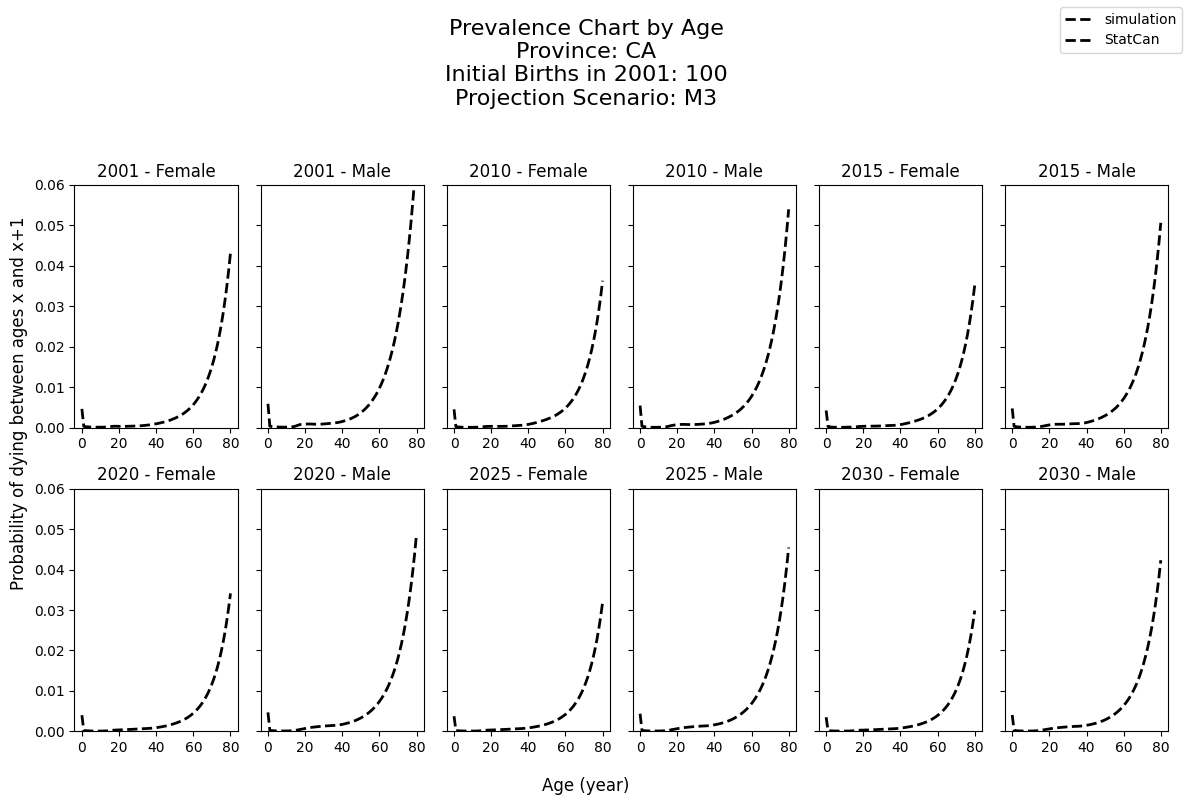

In [22]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols * 2,
                        figsize=(4 * num_cols, 4 * num_rows), sharey=True)

# Loop over figure years to make one plot per year
for i, year in enumerate(figure_years):
    for j, sex in enumerate(['F', 'M']):
        # Get axis for current plot by indexing with i and j
        if num_rows == 1:
            ax: plt.Axes = axs[i * 2 + j] if num_cols == 1 else axs[i * 2 + j]
        else:
            ax: plt.Axes = axs[i // num_cols][i % num_cols * 2 + j]

        # Filter observed df by current year and sex
        fig4df = target_mortality_df[
            (target_mortality_df['year'] == year) &
            (target_mortality_df['sex'] == sex)]

        ax.plot(fig4df["age"], fig4df["prob_death"],
                color="black", linestyle="dashed", linewidth=2)

        # Set title and axis limits
        ax.set_title(f"{year} - {'Female' if sex == 'F' else 'Male'}", fontsize=12)
        ax.set_ylim(0, 0.06)
        ax.set_xticks([0, 20, 40, 60, 80])

# Additional figure details
fig.supxlabel("Age (year)")
fig.supylabel("Probability of dying between ages x and x+1")
fig.suptitle(
    f"Prevalence Chart by Age\n" +
    f"Province: {PROVINCE}\n" +
    f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n" +
    f"Projection Scenario: {PROJECTION_SCENARIO}",
    fontsize=16
)
fig.legend(["simulation", "StatCan"])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Figure 5.

Population by age across selected years from the model (grey solid) and from Statistics Canada (black dashed).

### Load Data

In [54]:
# Stats Canada Population Data
target_pop_df = pd.read_csv(get_data_path("processed_data/birth/initial_pop_distribution_prop.csv"))

# Simulation Population Data
model_pop_df = pd.read_csv(pathlib.Path(PATH_OUTPUT, f"{RUN_BUNDLE_NAME}/outcome_matrix_alive.csv"))

### Process Data

In [55]:
# Filter to only include dates after chosen starting year
target_pop_df = target_pop_df[
    (target_pop_df['year'] >= STARTING_YEAR)
]
# Rename target column for clarity
target_pop_df = target_pop_df.rename(columns={"n_age": "n_alive_target"})
# Only keep relevent columns
target_pop_df = target_pop_df[['year', 'age', 'n_alive_target']]


# Filter to only include dates after chosen starting year
model_pop_df = model_pop_df[model_pop_df["year"] >= STARTING_YEAR]
# Group sexes together for ages and years
model_pop_df = model_pop_df.groupby(['year', 'age']).sum().reset_index()
# Rename model column for clarity
model_pop_df = model_pop_df.rename(columns={"n_alive": "n_alive_model"})

# Merge the filtered Canada population data and simulation population data
fig5_df = pd.merge(
    target_pop_df,
    model_pop_df,
    on=["year", "age"]
)

### Plot Data

In [56]:
# Figure Parameters
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

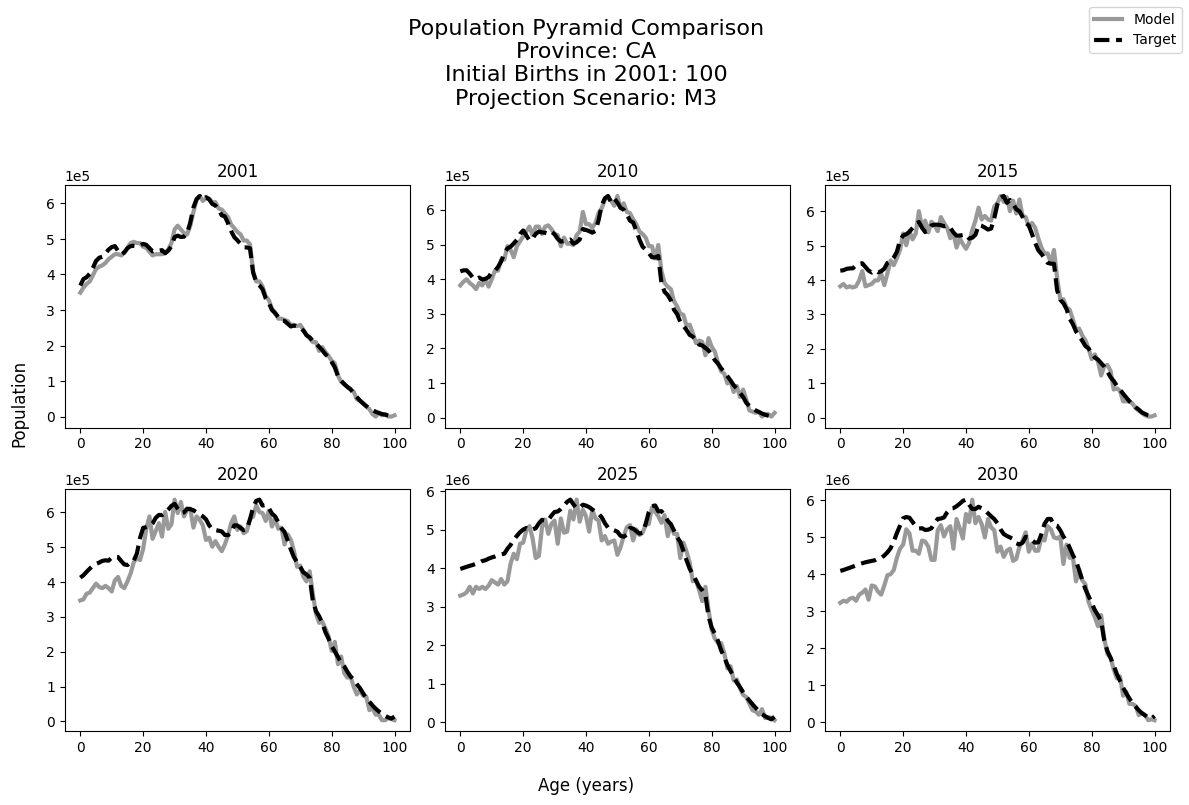

In [57]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_cols, 4 * num_rows))

# Loop over figure years to make one plot per year
for i, year in enumerate(figure_years):
    # Get axis for current plot by indexing with i
    if num_rows == 1:
        if num_cols == 1:
            ax: plt.Axes = axs
        else:
            ax: plt.Axes = axs[i % num_cols]
    else:
        ax: plt.Axes = axs[i // num_cols][i % num_cols]

    # Filter by current year
    fig5_filtered_df = fig5_df[fig5_df["year"] == year]
    # Group by age and sum over sexes to current number of population for each age
    fig5_filtered_df = fig5_filtered_df.groupby("age").sum().reset_index()

    # Scale the simulation data to match the maximum population of the stats data
    max_stats_age = fig5_filtered_df["n_alive_target"].max()
    max_simulation_age = fig5_filtered_df["n_alive_model"].max()
    scaling_factor = max_stats_age / max_simulation_age
    fig5_filtered_df["n_alive_model"] *= scaling_factor

    # Plot simulation data
    ax.plot(fig5_filtered_df["age"], fig5_filtered_df["n_alive_model"],
            color="#999999", linestyle="-", linewidth=3, label="simulated")
    # Plot historical and projected data from Stats Canada
    ax.plot(fig5_filtered_df["age"], fig5_filtered_df["n_alive_target"],
            color="black", linestyle="dashed", linewidth=3, label="observed")

    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)
    ax.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

# Additional labels
fig.supxlabel("Age (years)")
fig.supylabel("Population")
fig.suptitle(
    f"Population Pyramid Comparison\n"+
    f"Province: {PROVINCE}\n"+
    f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n"+
    f"Projection Scenario: {PROJECTION_SCENARIO}", 
    fontsize=16
)
fig.legend(["Model", "Target"])
plt.tight_layout(rect=[0.01, 0, 1, 0.95])
plt.show()

## Figure 6.

Rate of antibiotic prescriptions by sex (red: females; blue: males) for simulated (solid) and target values (dotted),
with the floor rate of 50 per 1000 (purple).

### Load Data

In [58]:
# Define colors to plot for different sexs
sex_colour_dict = {"Male": "#09bfc4", "Female": "#f86d63"}

# Load antibiotic data from StatsCanada
target_abx_df = pd.read_csv(get_data_path("processed_data/InfantAbxBC.csv"))

# Load antibiotic data from simulation
model_abx_df = pd.read_csv(
    pathlib.Path(PATH_OUTPUT, RUN_BUNDLE_NAME, "outcome_matrix_antibiotic_exposure.csv")
)

# Load additional simulation data for population comparisson
model_infant_alive_df = pd.read_csv(pathlib.Path(PATH_OUTPUT, RUN_BUNDLE_NAME,
                    "outcome_matrix_alive.csv"))
model_infant_death_df = pd.read_csv(pathlib.Path(PATH_OUTPUT, RUN_BUNDLE_NAME,
                    "outcome_matrix_death.csv"))
model_infant_emigration_df = pd.read_csv(pathlib.Path(PATH_OUTPUT, RUN_BUNDLE_NAME,
                         "outcome_matrix_emigration.csv"))

### Process Data

In [59]:
# Merge all datasets on Year, Sex, and Age
fig6_df = model_abx_df.rename(columns={'n_antibiotic_exposure': 'n'}).merge(
    model_infant_alive_df, on=['year', 'sex', 'age']
).merge(
    model_infant_death_df, on=['year', 'sex', 'age']
).merge(
    model_infant_emigration_df, on=['year', 'sex', 'age']
)

# Filter for age 0
fig6_df = fig6_df[fig6_df['age'] == 0].copy()

# Compute total population (N) and rate per 1,000
fig6_df["N"] = fig6_df["n_alive"] + fig6_df["n_deaths"] + fig6_df["n_emigrants"]
fig6_df["rate"] = (fig6_df["n"] / fig6_df["N"]) * 1000

# Map sex values for labeling
fig6_df["sex"] = fig6_df["sex"].map({"F": "Female", "M": "Male"})

### Plot Data

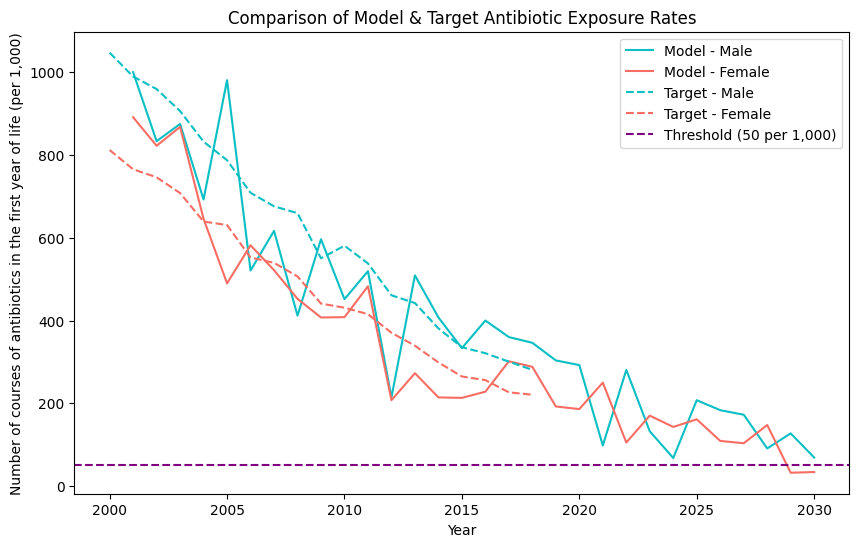

In [60]:
# Plotting
plt.figure(figsize=(10, 6))

# Plot simulated data (solid lines)
for gender in ["Male", "Female"]:
    subset = fig6_df[fig6_df["sex"] == gender]
    plt.plot(subset["year"], subset["rate"],
             label=f"Model - {gender}", color=sex_colour_dict[gender])

# Plot reference data (dashed lines)
for gender in ["Male", "Female"]:
    subset = target_abx_df[target_abx_df["sex"] == gender]
    plt.plot(subset["year"], subset["rate"], linestyle="dashed",
             label=f"Target - {gender}", color=sex_colour_dict[gender])

# Add horizontal reference line
plt.axhline(y=50, color="purple", linestyle="dashed", label="Threshold (50 per 1,000)")

# Labels, legend, and formatting
plt.xlabel("Year")
plt.ylabel("Number of courses of antibiotics in the first year of life (per 1,000)")
plt.legend()
plt.title("Comparison of Model & Target Antibiotic Exposure Rates")
plt.show()

## Figure 7.

Asthma prevalence rates per 1000 general population by sex (left: females; right: males) from the model (grey solid) and estimated or projected (black dashed).

### Load Data

In [61]:
# Read obsereved StatsCanada asthma prevalence data
target_prev_df = pd.read_csv(get_data_path("processed_data/master_asthma_prev_inc.csv"))

# Read simulation asthma prevalence data
model_prev_df = pd.read_csv(
    pathlib.Path(PATH_OUTPUT, f"{RUN_BUNDLE_NAME}/outcome_matrix_asthma_prevalence.csv")
)
# Read total population data
model_alive_df = pd.read_csv(pathlib.Path(PATH_OUTPUT, RUN_BUNDLE_NAME,
                    "outcome_matrix_alive.csv"))

### Process Data

In [62]:
# Filter StatsCanada day by ages under 65 years for the figure
target_prev_df = target_prev_df[target_prev_df["age"] <= 65]
# Change sex data type from boolean {0, 1} to letter {'F', 'M'}
target_prev_df['sex'] = target_prev_df['sex'].map(lambda s: "F" if s == 0 else "M")
# Scale up prev values by 1000 for the y-axis
target_prev_df['prev'] *= 1000

# Filter simulation data by ages under 65 year
model_prev_df = model_prev_df[model_prev_df["age"] <= 65]
# Merge model_prev_df with model_alive_df to get n_alive for each row
model_prev_df = model_prev_df.merge(model_alive_df, on=['year', 'age', 'sex'])
# Calculate n_prev as n_asthma / n_alive
model_prev_df['prev'] = model_prev_df['n_asthma'] / model_prev_df['n_alive'] * 1000

### Plot Data

In [63]:
# Figure Parameters
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

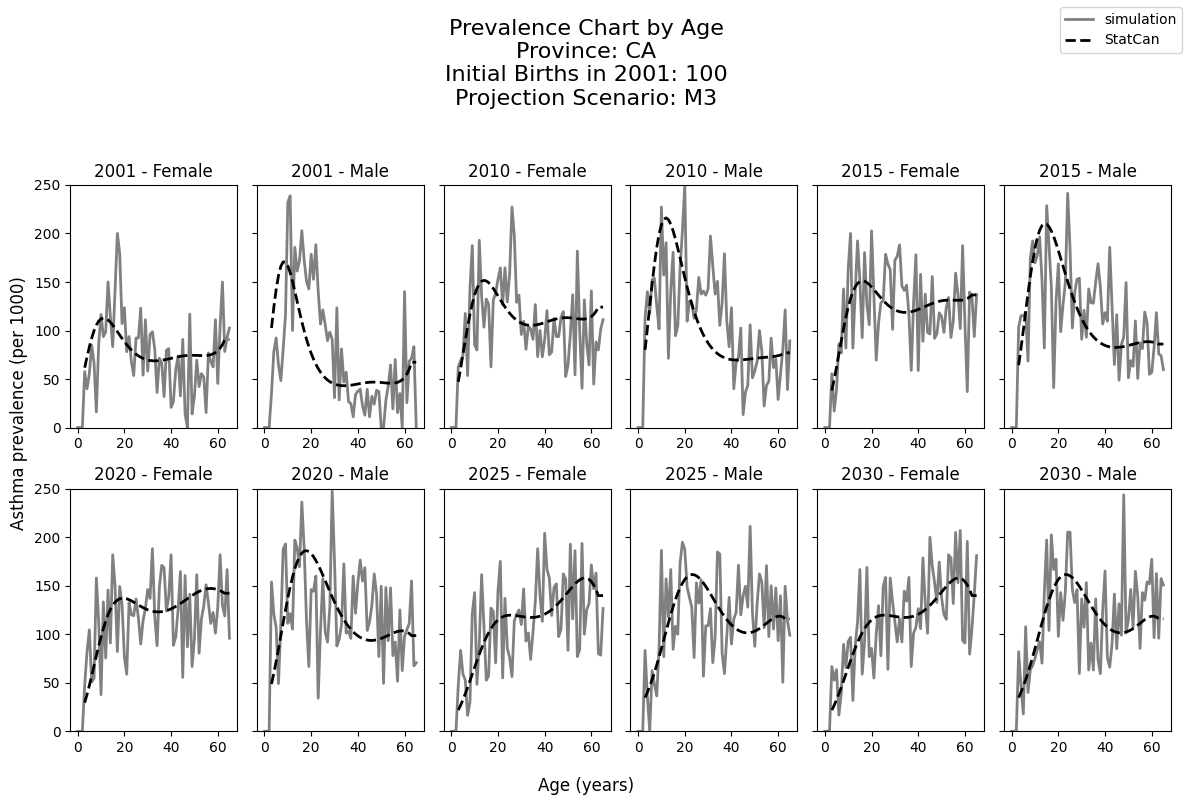

In [64]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols * 2,
                        figsize=(4 * num_cols, 4 * num_rows), sharey=True)

# Loop over figure years to make one plot per year
for i, year in enumerate(figure_years):
    for j, sex in enumerate(['F', 'M']):
        # Get axis for current plot by indexing with i and j
        if num_rows == 1:
            ax: plt.Axes = axs[i * 2 + j] if num_cols == 1 else axs[i * 2 + j]
        else:
            ax: plt.Axes = axs[i // num_cols][i % num_cols * 2 + j]

        # Filter simulation df by current year and sex
        model_prev_filtered_df = model_prev_df[(
            model_prev_df['year'] == year) & (model_prev_df['sex'] == sex)]

        # Filter observed df by current year and sex
        target_prev_filtered_df = target_prev_df[(
            target_prev_df['year'] == year) & (target_prev_df['sex'] == sex)]

        ax.plot(model_prev_filtered_df["age"], model_prev_filtered_df["prev"],
                color="grey", linestyle="solid", linewidth=2)
        ax.plot(target_prev_filtered_df["age"], target_prev_filtered_df["prev"],
                color="black", linestyle="dashed", linewidth=2)

        # Set title and axis limits
        ax.set_title(f"{year} - {'Female' if sex == 'F' else 'Male'}", fontsize=12)
        ax.set_ylim(0, 250)

# Additional figure details
fig.supxlabel("Age (years)")
fig.supylabel("Asthma prevalence (per 1000)")
fig.suptitle(
    f"Prevalence Chart by Age\n" +
    f"Province: {PROVINCE}\n" +
    f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n" +
    f"Projection Scenario: {PROJECTION_SCENARIO}",
    fontsize=16
)
fig.legend(["simulation", "StatCan"])
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Figure 8.
Asthma control levels (red: well-controlled; green: partially controlled; blue: uncontrolled) by the model (solid) and target (dashed).

### Load Data

In [65]:
# Read in simulation control data
model_exac_severity_df = pd.read_csv(pathlib.Path(
    PATH_OUTPUT, f"{RUN_BUNDLE_NAME}/outcome_matrix_control.csv"))

### Process Data

In [66]:
# Validation parameters
TARGET_WC = 0.35
TARGET_PC = 0.47
TARGET_UC = 0.18

# Filter by levels
model_exac_level0_df = model_exac_severity_df[model_exac_severity_df["level"] == 0]  # UC
model_exac_level1_df = model_exac_severity_df[model_exac_severity_df["level"] == 1]  # PC
model_exac_level2_df = model_exac_severity_df[model_exac_severity_df["level"] == 2]  # WC

# Sum over sexes and years
model_exac_level0_total = model_exac_level0_df.groupby(
    ['year'])['prob'].sum().reset_index()
model_exac_level1_total = model_exac_level1_df.groupby(
    ['year'])['prob'].sum().reset_index()
model_exac_level2_total = model_exac_level2_df.groupby(
    ['year'])['prob'].sum().reset_index()

# Normalize over 3 levels
for year in model_exac_level0_total['year'].unique():
    p0 = model_exac_level0_total.loc[model_exac_level0_total['year'] == year, 'prob'].values
    p1 = model_exac_level1_total.loc[model_exac_level1_total['year'] == year, 'prob'].values
    p2 = model_exac_level2_total.loc[model_exac_level2_total['year'] == year, 'prob'].values
    total = p0 + p1 + p2
    model_exac_level0_total.loc[model_exac_level0_total['year'] == year, 'prob'] /= total
    model_exac_level1_total.loc[model_exac_level1_total['year'] == year, 'prob'] /= total
    model_exac_level2_total.loc[model_exac_level2_total['year'] == year, 'prob'] /= total
    

### Plot Data

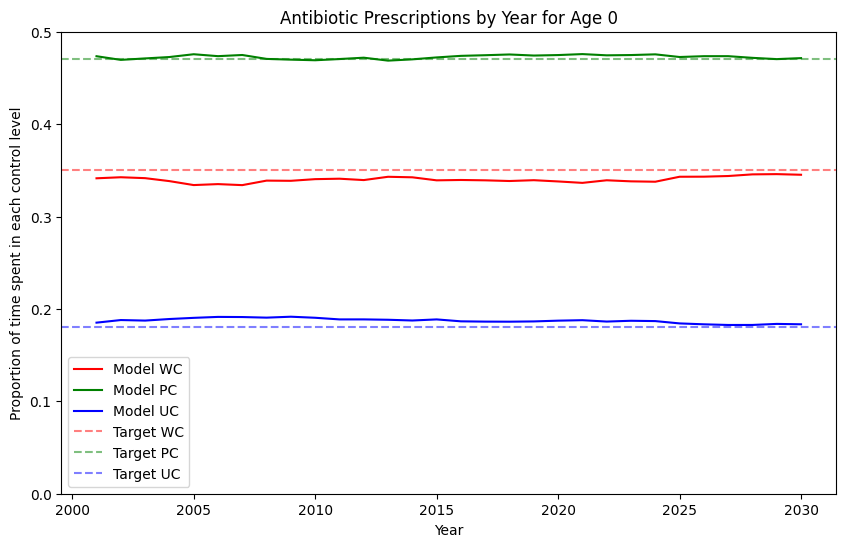

In [67]:
# Plotting parameters
plt.figure(figsize=(10, 6))

# Create plots for each level
plt.plot(model_exac_level0_total['year'], model_exac_level0_total['prob'],
         label='Model WC', color='red', linestyle='solid')
plt.plot(model_exac_level1_total['year'], model_exac_level1_total['prob'],
         label='Model PC', color='green', linestyle='solid')
plt.plot(model_exac_level2_total['year'], model_exac_level2_total['prob'],
         label='Model UC', color='blue', linestyle='solid')
# Plot horizontal target values
plt.axhline(y=TARGET_WC, label='Target WC',
            color='red', linestyle='dashed', alpha=0.5)
plt.axhline(y=TARGET_PC, label='Target PC',
            color='green', linestyle='dashed', alpha=0.5)
plt.axhline(y=TARGET_UC, label='Target UC',
            color='blue', linestyle='dashed', alpha=0.5)

# Additional elements
plt.ylim(0, 0.5)
plt.xlabel("Year")
plt.ylabel("Proportion of time spent in each control level")
plt.title("Antibiotic Prescriptions by Year for Age 0")
plt.legend()
plt.show()

## Figure 9.
Simulated (solid) and target (dotted) asthma exacerbation severity levels (red: mild; blue: moderate; green: severe; purple: very severe).

### Load Data

In [68]:
# Read in simulation control data
model_exac_severity_df = pd.read_csv(pathlib.Path(
    PATH_OUTPUT, f"{RUN_BUNDLE_NAME}/outcome_matrix_exacerbation_by_severity.csv"))

### Process Data

In [69]:
# Validation parameters
TARGET_MILD = 0.495
TARGET_MODERATE = 0.195
TARGET_SEVERE = 0.283
TARGET_VERY_SEVERE = 0.026

# Filter by levels
model_exac_level0_df = model_exac_severity_df[model_exac_severity_df["severity"] == 0]  # mild
model_exac_level1_df = model_exac_severity_df[model_exac_severity_df["severity"] == 1]  # moderate
model_exac_level2_df = model_exac_severity_df[model_exac_severity_df["severity"] == 2]  # severe
# very severe
model_exac_level3_df = model_exac_severity_df[model_exac_severity_df["severity"] == 3]

# Sum over sexes and years
model_exac_level0_total = model_exac_level0_df.groupby(
    ['year'])['p_exacerbations'].sum().reset_index()
model_exac_level1_total = model_exac_level1_df.groupby(
    ['year'])['p_exacerbations'].sum().reset_index()
model_exac_level2_total = model_exac_level2_df.groupby(
    ['year'])['p_exacerbations'].sum().reset_index()
model_exac_level3_total = model_exac_level3_df.groupby(
    ['year'])['p_exacerbations'].sum().reset_index()

# Normalize over 4 severities
for year in model_exac_level0_total['year'].unique():
    p0 = model_exac_level0_total.loc[model_exac_level0_total['year']
                                     == year, 'p_exacerbations'].values
    p1 = model_exac_level1_total.loc[model_exac_level1_total['year']
                                     == year, 'p_exacerbations'].values
    p2 = model_exac_level2_total.loc[model_exac_level2_total['year']
                                     == year, 'p_exacerbations'].values
    p3 = model_exac_level3_total.loc[model_exac_level3_total['year']
                                     == year, 'p_exacerbations'].values
    total = p0 + p1 + p2 + p3
    model_exac_level0_total.loc[model_exac_level0_total['year'] == year, 'p_exacerbations'] /= total
    model_exac_level1_total.loc[model_exac_level1_total['year'] == year, 'p_exacerbations'] /= total
    model_exac_level2_total.loc[model_exac_level2_total['year'] == year, 'p_exacerbations'] /= total
    model_exac_level3_total.loc[model_exac_level3_total['year'] == year, 'p_exacerbations'] /= total

### Plot Data

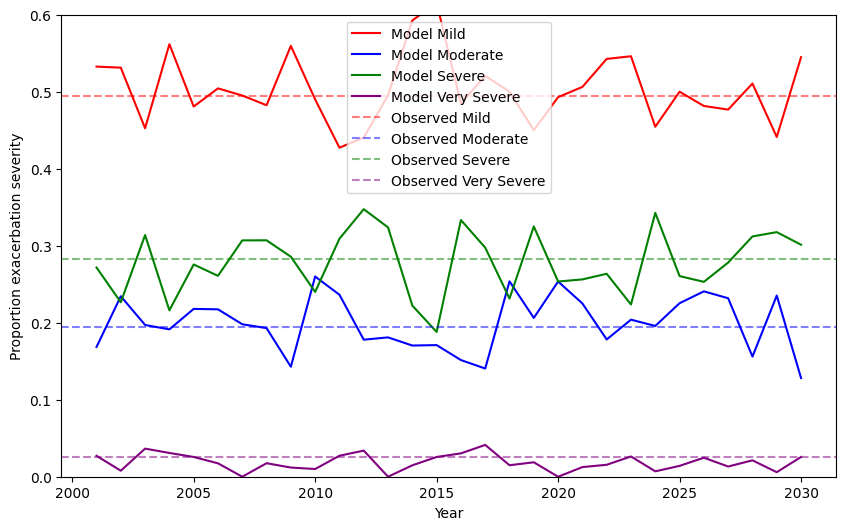

In [70]:
# Plotting parameters
plt.figure(figsize=(10, 6))

# Create plots for each severity level
plt.plot(model_exac_level0_total['year'], model_exac_level0_total['p_exacerbations'],
         label='Model Mild', color='red', linestyle='solid')
plt.plot(model_exac_level1_total['year'], model_exac_level1_total['p_exacerbations'],
         label='Model Moderate', color='blue', linestyle='solid')
plt.plot(model_exac_level2_total['year'], model_exac_level2_total['p_exacerbations'],
         label='Model Severe', color='green', linestyle='solid')
plt.plot(model_exac_level3_total['year'], model_exac_level3_total['p_exacerbations'],
         label='Model Very Severe', color='purple', linestyle='solid')
# Plot horizontal target values
plt.axhline(y=TARGET_MILD, label='Observed Mild',
            color='red', linestyle='dashed', alpha=0.5)
plt.axhline(y=TARGET_MODERATE, label='Observed Moderate',
            color='blue', linestyle='dashed', alpha=0.5)
plt.axhline(y=TARGET_SEVERE, label='Observed Severe',
            color='green', linestyle='dashed', alpha=0.5)
plt.axhline(y=TARGET_VERY_SEVERE, label='Observed Very Severe',
            color='purple', linestyle='dashed', alpha=0.5)

# Additional elements
plt.ylim(0, 0.6)
plt.xlabel("Year")
plt.ylabel("Proportion exacerbation severity")
plt.legend()
plt.show()